# Imports

- Imports
    - pip install pandas
    - pip install seaborn
    - pip install matplotlib
- Set n\_jobd parameter where possible to help speed up the run

In [49]:
# General imports
import os
import re
import string

# Dataframe processing imports
import pandas
import numpy

# Data Visualisation imports
import seaborn
import matplotlib.pyplot as pyplot

# NLP related stuffs
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download("wordnet")
wordnet_words = set(wordnet.words())

# Machine Learning imports
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dillo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dillo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Experiment configuration

- Set Scikit learn parralelsm
- Set folder to save charts

In [50]:
# set number of jobs
# ideally use aout 80% of available CPUs
model_n_jobs = 8

In [51]:
# Folder to store the visuals
if not os.path.exists('charts'):
    os.makedirs('charts')

# Dataset Creation

## Data Ingestion

1. Load the data into a data frame

In [52]:
swearjar_train_df = pandas.read_csv('source/train.csv')
swearjar_test_df = pandas.read_csv('source/test.csv')
swearjar_sample_submission_df = pandas.read_csv('source/sample_submission.csv')

# check the shape and first few rows of the dataframe
print(swearjar_train_df.shape)
swearjar_train_df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Quick Data Validation

- Dataset overview
- Descriptive statistices
- Check number of sentences and tokens per class
- Display most common words for each class
    - Stop words removed
    - Words must not be alphanumeric

In [53]:
swearjar_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [54]:
swearjar_train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
#Check number of sentences and tokens per class
# Define a function to count sentences and tokens
def count_sentences_tokens(text):
    sentences = sent_tokenize(text)
    tokens = word_tokenize(text)
    return len(sentences), len(tokens)

# Create a new DataFrame to store the results
class_sentences_tokens_df = pandas.DataFrame(columns=['Class', 'Sentence Count', 'Token Count'])

# Create a list to store DataFrames
dfs = []

for label in swearjar_train_df.columns[2:]:
    class_data = swearjar_train_df[swearjar_train_df[label] == 1]
    total_sentences = 0
    total_tokens = 0
    for _, row in class_data.iterrows():
        sentences, tokens = count_sentences_tokens(row['comment_text'])
        total_sentences += sentences
        total_tokens += tokens
    
    # Create a temporary DataFrame for the current class
    temp_df = pandas.DataFrame({'Class': label, 'Sentence Count': total_sentences, 'Token Count': total_tokens}, index=[0])
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df)

# Concatenate all DataFrames in the list
class_sentences_tokens_df = pandas.concat(dfs, ignore_index=True)

print(class_sentences_tokens_df)

           Class  Sentence Count  Token Count
0          toxic           65681       966200
1   severe_toxic           12023       161132
2        obscene           36956       514203
3         threat            2969        38651
4         insult           33357       467734
5  identity_hate            5409        85984


## Text Preprocessing

- Clean the text, remove punctuation, clean up words, remove incorrect spaces
- Stop word removal - NLTK
- Stemming - Snowball Stemmer

This needs to be done to both the train and test set

In [56]:
# Initialize lemmatizer
stemmer = SnowballStemmer("english")

# Function to Preprocesses the text
def preprocess_text(text):
 
    # make everything lowercase
    text = text.lower()
    # cleanup swear words
    text = re.sub(r'fck', 'fuck', text)
    text = re.sub(r'f\W\Wk', 'fuck', text)
    text = re.sub(r'sh\Wt', 'shit', text)
    text = re.sub(r'd\Wck', 'dick', text)

    # get rid of junk
    # To avoid removal of spaces all removals are replaced with a space, the final regex step will clean this up
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    # get rid of spaces
    text = re.sub('\s+', ' ', text) # double spaces
    text = re.sub('^[\s]+', '', text) # leading space
    
    # Tokenize comment_text
    words = nltk.word_tokenize(text)

    # Stem words, and stop word removal
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    return ' '.join(words)

# Fill empty and NaNs values with 'unknown' in comment_text
swearjar_train_df['comment_text'] = swearjar_train_df['comment_text'].fillna("unknown")
# Apply processing to test set
swearjar_test_df['comment_text'] = swearjar_test_df['comment_text'].fillna("unknown")

# Apply preprocessing to comment_text
swearjar_train_df['comment_text_processed'] = swearjar_train_df['comment_text'].apply(preprocess_text)
# Apply processing to test set
swearjar_test_df['comment_text_processed'] = swearjar_test_df['comment_text'].apply(preprocess_text)


# Drop comment_text to save memory
swearjar_train_df = swearjar_train_df.drop('comment_text', axis=1)
# Apply processing to test set
swearjar_test_df = swearjar_test_df.drop('comment_text', axis=1)

swearjar_train_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_processed
0,0000997932d777bf,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...
1,000103f0d9cfb60f,0,0,0,0,0,0,aww match background colour seem stuck thank t...
2,000113f07ec002fd,0,0,0,0,0,0,hey man realli tri edit war guy constant remov...
3,0001b41b1c6bb37e,0,0,0,0,0,0,make real suggest improv wonder section statis...
4,0001d958c54c6e35,0,0,0,0,0,0,sir hero chanc rememb page


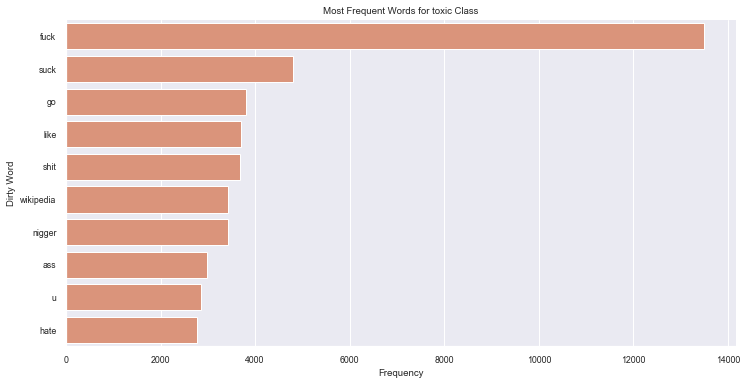

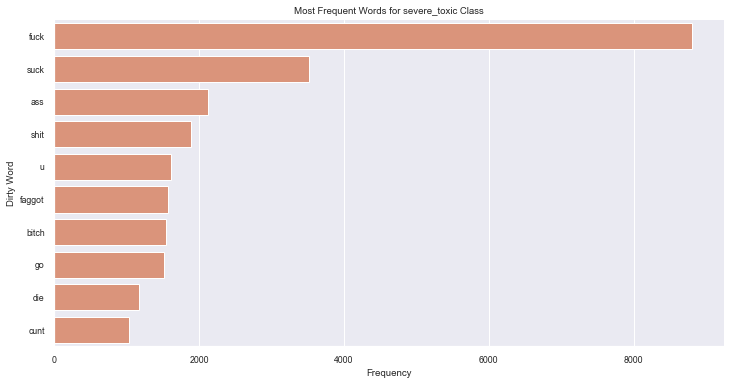

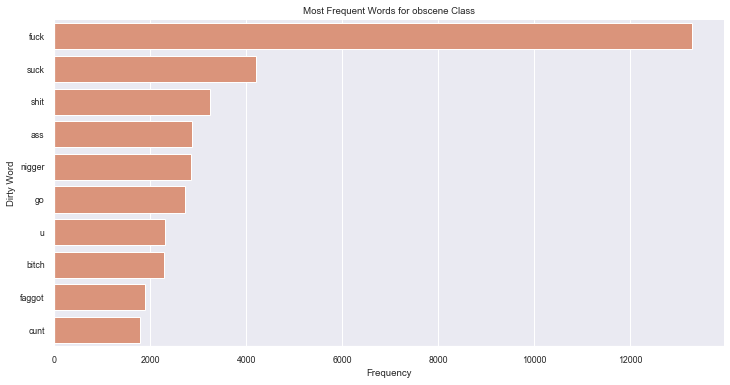

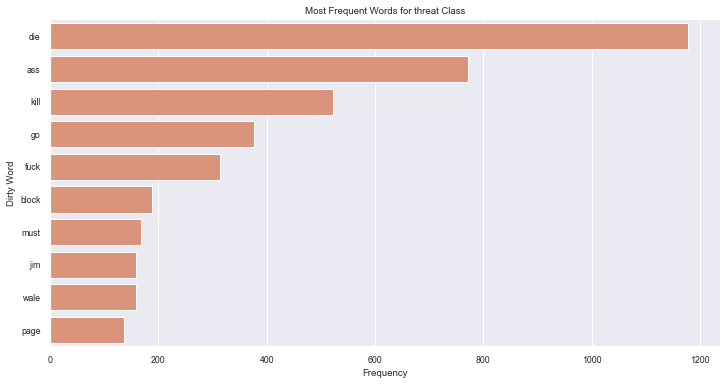

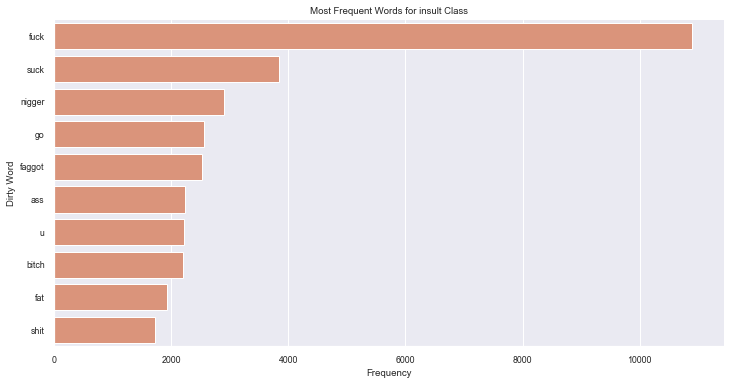

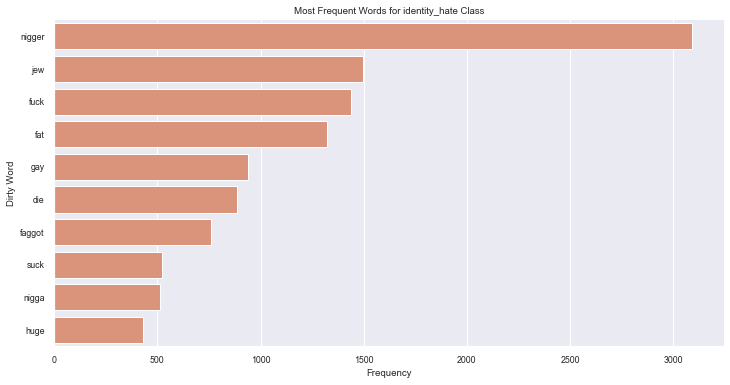

In [57]:
# Create a new DataFrame to store word frequency counts
word_freq_df = pandas.DataFrame(columns=['Class', 'Word', 'Frequency'])

# Create a list to store DataFrames
dfs = []

for label in swearjar_train_df.columns[1:7]:
    class_data = swearjar_train_df[swearjar_train_df[label] == 1]
    
    all_words = []
    for _, row in class_data.iterrows():
        words = row['comment_text_processed'].split()
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    
    # Create a temporary DataFrame for the current class
    temp_df = pandas.DataFrame({'Class': label, 'Word': list(word_counts.keys()), 'Frequency': list(word_counts.values())})
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df)

# Concatenate all DataFrames in the list
word_freq_df = pandas.concat(dfs, ignore_index=True)

# Sort the DataFrame by frequency for each class
word_freq_df.sort_values(by=['Class', 'Frequency'], ascending=False, inplace=True)

# Create a bar plot for each class
for label in swearjar_train_df.columns[1:7]:

    # Set figure size and font size
    pyplot.figure(figsize=(12, 6))
    seaborn.set(font_scale=0.8)
    seaborn.set_palette("flare")

    # Filter the DataFrame for the current class
    class_data = word_freq_df[word_freq_df['Class'] == label]
    seaborn.barplot(x='Frequency', y='Word', data=class_data.head(10))

    # Set the title, x-axis label, and y-axis label
    pyplot.title(f'Most Frequent Words for {label} Class')
    pyplot.xlabel('Frequency')
    pyplot.ylabel('Dirty Word')

    # Remove unnecessary spines and grid lines
    seaborn.despine()

    # Save the plot
    pyplot.savefig(f'charts/word_fequency_{label}_class_barchart.png')

# Feature Engineering

## Classify the data into features and targets

- Label the data
    
    - we will also create a none label

In [58]:
# Labels
HateLabels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
swearjar_train_df['none'] = 1 - swearjar_train_df[HateLabels].max(axis=1)
swearjar_train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualise the Data

- Check if there is any correlation between the labels and targets

[https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/](https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/)

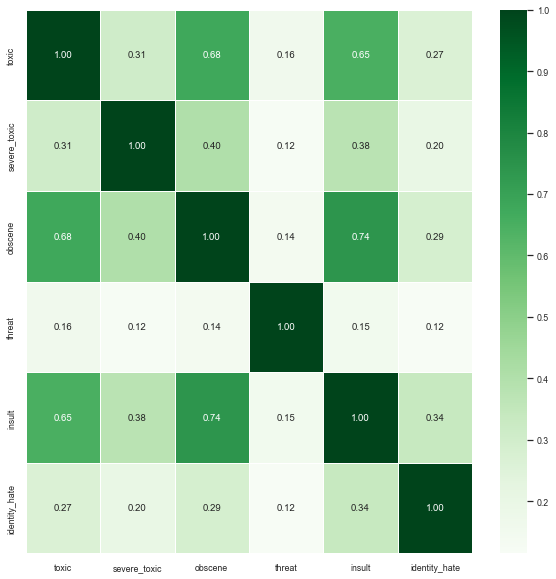

In [59]:
hate_correlation = swearjar_train_df[HateLabels].corr()
pyplot.figure(figsize=(10, 10))
seaborn.heatmap(hate_correlation, annot=True, cmap='Greens', fmt=".2f", linewidth=.5)

# Save the plot
pyplot.savefig('charts/target_test_correlationmatrix.png')

# Model Training

- <span style="color: rgb(60, 64, 67); font-family: Inter, sans-serif;">Vectorise the data</span>
- <span style="color: rgb(60, 64, 67); font-family: Inter, sans-serif;">Split data into train, and validation sets</span>
- <span style="color: rgb(60, 64, 67); font-family: Inter, sans-serif;">Logistic Regression</span>
- <span style="color: rgb(60, 64, 67); font-family: Inter, sans-serif;">Naive Bayes - Support Vector Machine;&nbsp;</span>     [https://nlp.stanford.edu/pubs/sidaw12\_simple\_sentiment.pdf](https:\nlp.stanford.edu\pubs\sidaw12_simple_sentiment.pdf)

## Feature Extraction

- TfidfVectorizer
- HashingVectorizer
- CountVectorizer

In [60]:
# TfidfVectorizer
# Define a tokeniser
def tokenize(text):
    words = nltk.word_tokenize(text)
    return words

vectorizer_selection = 'TfidfVectorizer' # TfidfVectorizer, CountVectorizer, HashingVectorizer

# Trigrams concidered, it will try anything that is a gram(ba dum tis)
if vectorizer_selection == 'TfidfVectorizer':
    vectorizer = TfidfVectorizer(ngram_range=(1,6), tokenizer=tokenize, min_df=10, max_df=0.9, strip_accents='unicode', use_idf=True, smooth_idf=True, sublinear_tf=True, max_features=20000)
elif vectorizer_selection == 'CountVectorizer':
    vectorizer = CountVectorizer(ngram_range=(1,6), tokenizer=tokenize, min_df=10, max_df=0.9, strip_accents='unicode', max_features=20000)
elif vectorizer_selection == 'HashingVectorizer':
    vectorizer = HashingVectorizer(ngram_range=(1,6), tokenizer=tokenize, n_features=20000)

# For model evaluation
# Fit the vectorizer to the training data
train_vec = vectorizer.fit_transform(swearjar_train_df['comment_text_processed'])
print(train_vec.shape)

# For the model we submit
submission_vec = vectorizer.transform(swearjar_test_df['comment_text_processed'])
print(submission_vec.shape)

C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(159571, 20000)


(153164, 20000)


## Split the Training set into Train and Test

In [61]:
x_train, x_valid, y_train, y_valid = train_test_split(train_vec,
                                                      swearjar_train_df[HateLabels], 
                                                      random_state=42, 
                                                      test_size=0.3, shuffle=True)


In [62]:
# Define a function to handle the model training and inference
def test_model(model, x_train, x_valid, y_train, y_valid):

    train_proba = numpy.zeros((x_train.shape[0],len(HateLabels)))
    validate_proba = numpy.zeros((x_valid.shape[0],len(HateLabels)))
    loss = []
    rocauc = []
    trained_model = {}

    for i,j in enumerate(HateLabels):
        print(f'Building {model} model for {j}')

        # Train the model
        model.fit(x_train, y_train[j])

        # Get Probabilities
        train_proba[:,1] = model.predict_proba(x_train)[:,1]
        validate_proba[:,1] = model.predict_proba(x_valid)[:,1]

        # Get Actual
        train_preds = model.predict(x_train)
        validate_preds = model.predict(x_valid)

        # Model Metrics
        loss.append(log_loss(y_valid[j],validate_proba[:,1]))
        rocauc.append(roc_auc_score(y_valid[j],validate_proba[:,1]))

        print('Training accuracy is {}'.format(accuracy_score(y_train[j],train_preds)))
        print('Validation accuracy is {}'.format(accuracy_score(y_valid[j],validate_preds)))
        print('Training F1 is {}'.format(f1_score(y_train[j],train_preds)))
        print('Validation F1 is {}'.format(f1_score(y_valid[j],validate_preds)))
        print('Training Precision is {}'.format(precision_score(y_train[j],train_preds)))
        print('Validation Precision is {}'.format(precision_score(y_valid[j],validate_preds)))
        print('Training Recall is {}'.format(recall_score(y_train[j],train_preds)))
        print('Validation Recall is {}'.format(recall_score(y_valid[j],validate_preds)))
        print('Training ROC AUC is {}'.format(roc_auc_score(y_train[j],train_proba[:,1])))
        print('Validation ROC AUC is {}'.format(roc_auc_score(y_valid[j],validate_proba[:,1])))
        print('')

        trained_model[j] = model

    print('mean column-wise log loss:Validation dataset', numpy.mean(loss))
    print('mean column-wise ROC AUC:Validation dataset', numpy.mean(rocauc))

    return trained_model

## <span style="color: rgb(60, 64, 67); font-family: Inter, sans-serif;">Logistic Regression</span>

In [63]:
# Logistic regression
model = LogisticRegression(C=2.2, solver='sag', n_jobs=model_n_jobs, max_iter=1000)
lr_model = test_model(model, x_train, x_valid, y_train, y_valid)

Building LogisticRegression(C=2.2, max_iter=1000, n_jobs=8, solver='sag') model for toxic


Training accuracy is 0.9662933419278597
Validation accuracy is 0.9597886029411765
Training F1 is 0.800127408823061
Validation F1 is 0.7572203304325892
Training Precision is 0.9275076923076923
Validation Precision is 0.8969226172691963


Training Recall is 0.7035100821508589
Validation Recall is 0.6551724137931034
Training ROC AUC is 0.9863005122081352
Validation ROC AUC is 0.9702948625689786

Building LogisticRegression(C=2.2, max_iter=1000, n_jobs=8, solver='sag') model for severe_toxic


Training accuracy is 0.9914144262706023
Validation accuracy is 0.9901194852941176
Training F1 is 0.40984615384615386
Validation F1 is 0.3134978229317852
Training Precision is 0.6453488372093024
Validation Precision is 0.5320197044334976
Training Recall is 0.30027051397655546
Validation Recall is 0.2222222222222222
Training ROC AUC is 0.9938524909961172


Validation ROC AUC is 0.9864014331818934

Building LogisticRegression(C=2.2, max_iter=1000, n_jobs=8, solver='sag') model for obscene


Training accuracy is 0.9831780051746211
Validation accuracy is 0.9788394050802139
Training F1 is 0.822919611723683
Validation F1 is 0.7731243001119821
Training Precision is 0.9253921153030945
Validation Precision is 0.9041382922996333
Training Recall is 0.7408790089937214
Validation Recall is 0.6752738654147105


Training ROC AUC is 0.9944928408575054
Validation ROC AUC is 0.986471076831227

Building LogisticRegression(C=2.2, max_iter=1000, n_jobs=8, solver='sag') model for threat


Training accuracy is 0.9973768789335625
Validation accuracy is 0.9973888703208557
Training F1 is 0.30403800475059384
Validation F1 is 0.25149700598802394
Training Precision is 0.810126582278481
Validation Precision is 0.6774193548387096
Training Recall is 0.1871345029239766
Validation Recall is 0.15441176470588236


Training ROC AUC is 0.9972189439507213
Validation ROC AUC is 0.9834658945277457

Building LogisticRegression(C=2.2, max_iter=1000, n_jobs=8, solver='sag') model for insult


Training accuracy is 0.9762307630327934
Validation accuracy is 0.9707553475935828
Training F1 is 0.7199662482860458
Validation F1 is 0.6491228070175439
Training Precision is 0.8547458051590283
Validation Precision is 0.8088694565896315
Training Recall is 0.621902332361516
Validation Recall is 0.5420678107994977
Training ROC AUC is 0.9893401345355426


Validation ROC AUC is 0.9762515605373356

Building LogisticRegression(C=2.2, max_iter=1000, n_jobs=8, solver='sag') model for identity_hate


Training accuracy is 0.9932855262804502
Validation accuracy is 0.9921875
Training F1 is 0.4444444444444444
Validation F1 is 0.3415492957746479
Training Precision is 0.7957559681697612
Validation Precision is 0.7132352941176471
Training Recall is 0.30832476875642345
Validation Recall is 0.22453703703703703


Training ROC AUC is 0.9932971956237111
Validation ROC AUC is 0.9786031624742365

mean column-wise log loss:Validation dataset 0.05209276020305029
mean column-wise ROC AUC:Validation dataset 0.9802479983535696


## Random Forest

In [64]:
# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state=42, n_jobs=model_n_jobs)
rf_model = test_model(model, x_train, x_valid, y_train, y_valid)

Building RandomForestClassifier(criterion='entropy', n_jobs=8, random_state=42) model for toxic


Training accuracy is 0.999059973679263
Validation accuracy is 0.9545036764705882
Training F1 is 0.9950831187075626
Validation F1 is 0.7113702623906706


Training Precision is 0.9983087475335901
Validation Precision is 0.9055330634278003
Training Recall is 0.9918782673637042
Validation Recall is 0.5857704059362724
Training ROC AUC is 0.9999169497470719
Validation ROC AUC is 0.9627356396452861

Building RandomForestClassifier(criterion='entropy', n_jobs=8, random_state=42) model for severe_toxic


Training accuracy is 0.9994538894708099
Validation accuracy is 0.9896599264705882
Training F1 is 0.9719540229885058
Validation F1 is 0.10810810810810811
Training Precision is 0.9915572232645403


Validation Precision is 0.43478260869565216
Training Recall is 0.9531109107303878
Validation Recall is 0.06172839506172839
Training ROC AUC is 0.9998165997264774
Validation ROC AUC is 0.9707919756820743

Building RandomForestClassifier(criterion='entropy', n_jobs=8, random_state=42) model for obscene


Training accuracy is 0.9992927421015407
Validation accuracy is 0.9766460561497327
Training F1 is 0.993276023491361
Validation F1 is 0.7414431082331174
Training Precision is 0.9964139344262295
Validation Precision is 0.9066742081447964
Training Recall is 0.9901578143560156
Validation Recall is 0.627151799687011
Training ROC AUC is 0.9999182024172715


Validation ROC AUC is 0.983069640787813

Building RandomForestClassifier(criterion='entropy', n_jobs=8, random_state=42) model for threat


Training accuracy is 0.9999373315786175
Validation accuracy is 0.9972008689839572
Training F1 is 0.9897209985315712
Validation F1 is 0.10666666666666667
Training Precision is 0.9941002949852508
Validation Precision is 0.5714285714285714


Training Recall is 0.9853801169590644
Validation Recall is 0.058823529411764705
Training ROC AUC is 0.9999896150870754
Validation ROC AUC is 0.9433158412937823

Building RandomForestClassifier(criterion='entropy', n_jobs=8, random_state=42) model for insult


Training accuracy is 0.9989077789416199
Validation accuracy is 0.9685619986631016
Training F1 is 0.9888543760277727
Validation F1 is 0.6069469835466179
Training Precision is 0.991572004397215
Validation Precision is 0.8069444444444445
Training Recall is 0.9861516034985423
Validation Recall is 0.486395981582252
Training ROC AUC is 0.9998552967396188
Validation ROC AUC is 0.969561587723607

Building RandomForestClassifier(criterion='entropy', n_jobs=8, random_state=42) model for identity_hate


Training accuracy is 0.999731421051218
Validation accuracy is 0.9914772727272727
Training F1 is 0.9843912591050988
Validation F1 is 0.13924050632911392
Training Precision is 0.9968387776606955
Validation Precision is 0.7857142857142857
Training Recall is 0.9722507708119219


Validation Recall is 0.0763888888888889
Training ROC AUC is 0.9998787642779742
Validation ROC AUC is 0.947767184474736

mean column-wise log loss:Validation dataset 0.0670111527796194
mean column-wise ROC AUC:Validation dataset 0.9628736449345497


## KNN

In [65]:
# KNN Classifier
model = KNeighborsClassifier(n_neighbors=5 ,metric = 'minkowski', p = 2, n_jobs=model_n_jobs)
knn_model = test_model(model, x_train, x_valid, y_train, y_valid)


Building KNeighborsClassifier(n_jobs=8) model for toxic


Training accuracy is 0.9301784259483075
Validation accuracy is 0.9147727272727273
Training F1 is 0.4831334084432368
Validation F1 is 0.3584905660377358
Training Precision is 0.8327621658670322
Validation Precision is 0.641169853768279
Training Recall is 0.3402725914861837
Validation Recall is 0.24879965080750763
Training ROC AUC is 0.9127102457297631
Validation ROC AUC is 0.6879179997578078

Building KNeighborsClassifier(n_jobs=8) model for severe_toxic


Training accuracy is 0.9914412841654805
Validation accuracy is 0.9896390374331551
Training F1 is 0.3469945355191257
Validation F1 is 0.17880794701986755
Training Precision is 0.7154929577464789
Validation Precision is 0.4576271186440678
Training Recall is 0.2290351668169522
Validation Recall is 0.1111111111111111
Training ROC AUC is 0.9801908828872696
Validation ROC AUC is 0.7369659676183639

Building KNeighborsClassifier(n_jobs=8) model for obscene


Training accuracy is 0.9634911682289009
Validation accuracy is 0.9569685828877005
Training F1 is 0.5052171802960447
Validation F1 is 0.40565493364108485
Training Precision is 0.8863346104725415
Validation Precision is 0.7725274725274726
Training Recall is 0.3533005260478534
Validation Recall is 0.2750391236306729
Training ROC AUC is 0.9452657414084816
Validation ROC AUC is 0.7189735432534202

Building KNeighborsClassifier(n_jobs=8) model for threat


Training accuracy is 0.9971351578796587
Validation accuracy is 0.997305314171123
Training F1 is 0.16230366492146597
Validation F1 is 0.1568627450980392
Training Precision is 0.775
Validation Precision is 0.7058823529411765
Training Recall is 0.09064327485380116
Validation Recall is 0.08823529411764706
Training ROC AUC is 0.9987068091996623
Validation ROC AUC is 0.6199681890101439

Building KNeighborsClassifier(n_jobs=8) model for insult


Training accuracy is 0.9628286734885719
Validation accuracy is 0.9563628008021391
Training F1 is 0.4536842105263158
Validation F1 is 0.34739144017494533
Training Precision is 0.8162878787878788
Validation Precision is 0.6847290640394089
Training Recall is 0.3141399416909621
Validation Recall is 0.23273336123901214
Training ROC AUC is 0.9438875083711057
Validation ROC AUC is 0.6993614567393829

Building KNeighborsClassifier(n_jobs=8) model for identity_hate


Training accuracy is 0.9918620578519056
Validation accuracy is 0.99139371657754
Training F1 is 0.15755329008341057
Validation F1 is 0.12340425531914893
Training Precision is 0.8018867924528302
Validation Precision is 0.7631578947368421
Training Recall is 0.08735868448098665
Validation Recall is 0.06712962962962964
Training ROC AUC is 0.9922111142048762
Validation ROC AUC is 0.6361709088673413

mean column-wise log loss:Validation dataset 0.5904623193075454
mean column-wise ROC AUC:Validation dataset 0.6832263442077432


# Submission

In [66]:
# lets submit random forest predictions
# Logistic regression
submission_proba = numpy.zeros((submission_vec.shape[0],len(HateLabels)))

for i,j in enumerate(HateLabels): 
    print('Scoring', j)
    submission_proba[:,i] = lr_model[j].predict_proba(submission_vec)[:,1] 

submid = pandas.DataFrame({'id': swearjar_sample_submission_df["id"]})
submission = pandas.concat([submid, pandas.DataFrame(submission_proba, columns = HateLabels)], axis=1)
submission.to_csv('submission.csv', index=False)

Scoring toxic
Scoring severe_toxic
Scoring obscene
Scoring threat
Scoring insult
Scoring identity_hate
